In [1]:
'''
This code finds the possible words and actual words for two Chinese affixes:
tou (头); zi (子)
Then it calculates the productivity of the two affixes
Some charts are visualized to show the statistics.
'''

'\nThis code finds the possible words and actual words for two Chinese affixes:\ntou (头); zi (子)\nThen it calculates the productivity of the two affixes\nSome charts are visualized to show the statistics.\n'

In [6]:
import pandas as pd
import OpenHowNet
import json
from tqdm import tqdm
import numpy as np 
import pickle
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = ['Heiti TC']
import seaborn
seaborn.set()

In [10]:
def SC2w(word_list, subClass):
    '''
    To get the actual word list featured on `subClass` for the `affix`
    '''
    w2c = getALLSubC(word_list)
    sc2w = {i:[] for i in subClass}
    for k,v in w2c.items():
        for j in v:
            sc = str(j).split("|")[-1]
            if sc in subClass:
                sc2w[sc].append(k)

    sc2w = {k:list(set(v)) for k,v in sc2w.items()}
                

    return sc2w

def possWords(wordDict):
    wordList = []
    w2c = {}

    for k,v in wordDict.items():
        wordList += v
        for vv in v:
            w2c[vv] = k

    print("There are %d instances, totally."%len(wordList))

    hownet_dict_advanced = OpenHowNet.HowNetDict(init_sim=True)
    w2poss = {}

    for i in tqdm(wordList):
        if len(i) != 2:
            w2poss[i] = []
            continue

        result_list = hownet_dict.get_sememes_by_word(word=i,display='dict')
        sense_list = []
        for se in result_list:
            if str(se['sememes']['children'][0]['name']).split("|")[-1] == w2c[i]:
                sense_list.append(se['sense'])

        near_dict = hownet_dict_advanced.get_nearest_words(i, language='zh', pos="noun")

        near_list = []
        for k,v in near_dict.items():
            if str(k) in str(sense_list):
                for vv in v:
                    if len(vv) == 1:
                        near_list.append(vv)

        # print(i)
        w2poss[i] = list(set(near_list))

    return w2poss

def prodScore(possDict, actuDict, useFF=False):
    '''
    Productivity scores given the possList and actuList
    '''
    prodDict = {k:[] for k,v in possDict.items()}
    nPoss = sum([len(v) for k,v in possDict.items()])
    for k,v in possDict.items():
        if len(v) != 0 :
            if useFF:
                FF = np.log(len(v) / nPoss + 1)
                # print("class: %s: %f" % (k, FF))
                prodDict[k] = round(len(actuDict[k]) / len(v) * FF, 4)
            else:
                prodDict[k] = round(len(actuDict[k]) / len(v), 4)
        else:
            prodDict[k] = 0.0

    return prodDict

def getALLSubC(affix_li):
    aff2cls = {}
    for w in affix_li:
        cls_li = [i['sememes']['children'][0]['name'] for i in hownet_dict.get_sememes_by_word(word=w,display='dict')]
        aff2cls[w] = cls_li

    return aff2cls

In [4]:
hownet_dict = OpenHowNet.HowNetDict()
subC = json.load(open("data/subclasses.json", "r"))

affix_zi = pd.read_csv("data/zi_samples.csv")['word'].to_list()
affix_tou = pd.read_csv("data/tou_samples.csv")['word'].to_list()

affix_zi_all = list(set(affix_zi))
affix_tou_all = list(set(affix_tou))

Initializing OpenHowNet succeeded!


In [7]:
# actual words
zi_sc2actuW = SC2w(affix_zi_all, subC)
tou_sc2actuW = SC2w(affix_tou_all, subC)

#%% possible words
word_list = hownet_dict.get_zh_words()
sc2possW = SC2w(word_list, subC)

# Reproduct below
# w2possW = possWords(tou_sc2actuW)
# zi_w2possW = possWords(zi_sc2actuW)

w2possW = pickle.load(open("data/tou_w2possW.pickle", "rb"))
zi_w2possW = pickle.load(open("data/zi_w2possW.pickle", "rb"))

In [8]:
zi_sc2actuW_n2 = {k:[vv for vv in v if len(vv) == 2] for k,v in zi_sc2actuW.items()}
tou_sc2actuW_n2 = {k:[vv for vv in v if len(vv) == 2] for k,v in tou_sc2actuW.items()}
zi_sc2possW_n2 = {k:[zi_w2possW[vv] for vv in v] for k,v in zi_sc2actuW_n2.items()}
tou_sc2possW_n2 = {k:[w2possW[vv] for vv in v] for k,v in tou_sc2actuW_n2.items()}

tou_sc2actuW_n2['位置'] += ['上头', '下头']

def toList(sc2possW_n2):
    for k,v in sc2possW_n2.items():
        temp = []
        for vv in v:
            temp += vv

        temp = list(set(temp))
        sc2possW_n2[k] = temp
    
    return sc2possW_n2

zi_sc2possW_n2 = toList(zi_sc2possW_n2)
tou_sc2possW_n2 = toList(tou_sc2possW_n2) 

zi_sc2possW_n2 = {k: list(set(v+[ff[0] for ff in zi_sc2actuW_n2[k]])) for k,v in zi_sc2possW_n2.items()}
tou_sc2possW_n2 = {k: list(set(v+[ff[0] for ff in tou_sc2actuW_n2[k]])) for k,v in tou_sc2possW_n2.items()}

In [11]:
# productivity scores
tou_prodDict = prodScore(tou_sc2possW_n2, tou_sc2actuW_n2)
zi_prodDict = prodScore(zi_sc2possW_n2, zi_sc2actuW_n2)

tou_prodDict_FF = prodScore(tou_sc2possW_n2, tou_sc2actuW_n2, useFF=True)
zi_prodDict_FF = prodScore(zi_sc2possW_n2, zi_sc2actuW_n2, useFF=True)

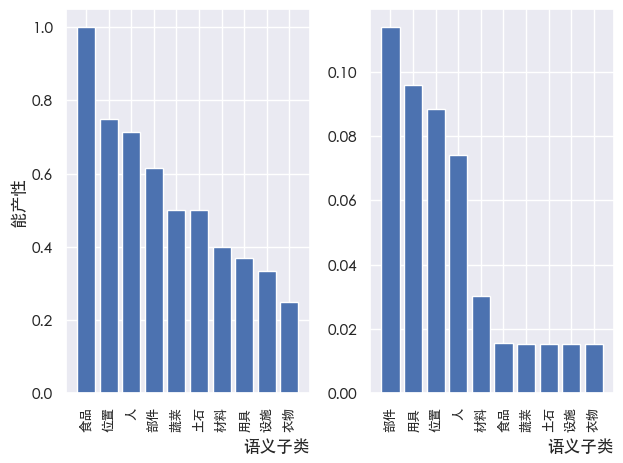

In [13]:
# statistics visualization
import matplotlib
matplotlib.rcParams['font.family'] = ['Heiti TC']
tou_prodDict_sort = [i for i in sorted(tou_prodDict.items(), key=lambda x: x[1], reverse=True) if i[1] > 0.0]
zi_prodDict_sort = [i for i in sorted(zi_prodDict.items(), key=lambda x: x[1], reverse=True) if i[1] > 0.0]

tou_prodDict_FF_sort = [i for i in sorted(tou_prodDict_FF.items(), key=lambda x: x[1], reverse=True) if i[1] > 0.0]
zi_prodDict_FF_sort = [i for i in sorted(zi_prodDict_FF.items(), key=lambda x: x[1], reverse=True) if i[1] > 0.0]

plt.subplot(1,2,1)

plt.bar(range(len(tou_prodDict_sort)), [i[1] for i in tou_prodDict_sort])
plt.xticks(range(len(tou_prodDict_sort)), [i[0] for i in tou_prodDict_sort], fontsize=9, rotation=90)
plt.xlabel("语义子类", horizontalalignment='right', x=1.0)
plt.ylabel("能产性")
# plt.title("后缀“头”的朴素能产性得分图")

plt.subplot(1,2,2)
plt.bar(range(len(tou_prodDict_FF_sort)), [i[1] for i in tou_prodDict_FF_sort])
plt.xticks(range(len(tou_prodDict_FF_sort)), [i[0] for i in tou_prodDict_FF_sort], fontsize=9, rotation=90)
plt.xlabel("语义子类", horizontalalignment='right', x=1.0)

plt.tight_layout()
# plt.ylim([])
# plt.ylabel("能产性")
# plt.title("后缀“头”的能产性得分图")
# plt.savefig("results/tou_prod.png")

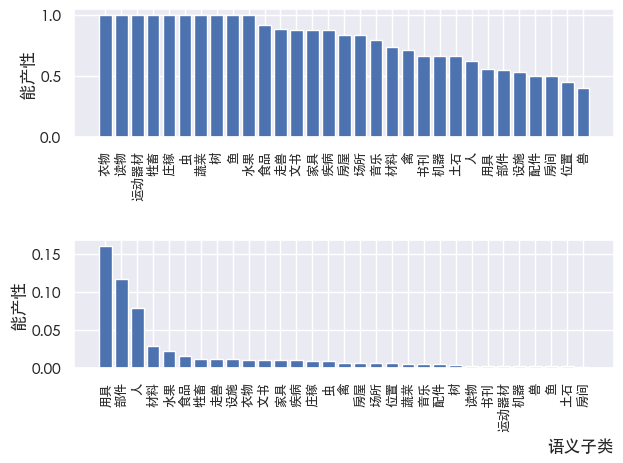

In [14]:
plt.subplot(2,1,1)

plt.bar(range(len(zi_prodDict_sort)), [i[1] for i in zi_prodDict_sort])
plt.xticks(range(len(zi_prodDict_sort)), [i[0] for i in zi_prodDict_sort], fontsize=9, rotation=90)
plt.xlabel(" ")
plt.ylabel("能产性")
# plt.title("后缀“子”的朴素能产性得分图")

plt.subplot(2,1,2)

plt.bar(range(len(zi_prodDict_FF_sort)), [i[1] for i in zi_prodDict_FF_sort])
plt.xticks(range(len(zi_prodDict_FF_sort)), [i[0] for i in zi_prodDict_FF_sort], fontsize=9, rotation=90)
plt.xlabel("语义子类", horizontalalignment='right', x=1.0)
plt.ylabel("能产性")
# plt.title("后缀“子”的能产性得分图")
plt.tight_layout()

# plt.savefig("results/zi_prod.png")

Text(0, 0.5, '能产性')

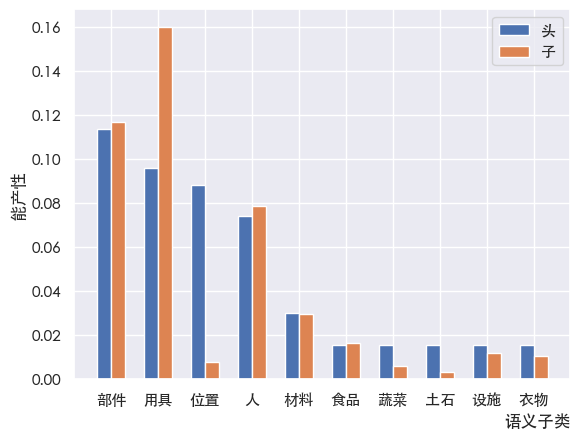

In [15]:
var = range(len(tou_prodDict_FF_sort))
wid = .3
# plt.figure(figsize=(6, 4))
plt.bar(np.array(var)-wid/2, [i[1] for i in tou_prodDict_FF_sort], width=wid, align='center', label="头")
plt.bar(np.array(var)+wid/2, [zi_prodDict_FF[i[0]] for i in tou_prodDict_FF_sort], width=wid, align='center', label="子")
plt.legend()
plt.xticks(var, [i[0] for i in tou_prodDict_FF_sort])
plt.xlabel("语义子类",horizontalalignment='right', x=1.0)
plt.ylabel("能产性")
# plt.savefig("results/prod_com.jpg")